In [1]:
import time

import numpy as np
import pybullet as p
import matplotlib.pyplot as plt
import seaborn as sns
import pybullet_data

from gym_pybullet_drones.utils.enums import DroneModel, Physics
from gym_pybullet_drones.envs.CtrlAviary import CtrlAviary
from controllers.pid_controller import DSLPIDControl
from controllers.lqr_controller import LQRControl
from controllers.mrac import MRAC
from gym_pybullet_drones.utils.Logger import Logger
from gym_pybullet_drones.utils.utils import sync, str2bool

DEFAULT_DRONES = DroneModel("cf2x")
DEFAULT_NUM_DRONES = 1
DEFAULT_PHYSICS = Physics("pyb")
DEFAULT_GUI = True
DEFAULT_RECORD_VISION = False
DEFAULT_PLOT = True
DEFAULT_USER_DEBUG_GUI = False
DEFAULT_OBSTACLES = False
DEFAULT_SIMULATION_FREQ_HZ = 240
DEFAULT_CONTROL_FREQ_HZ = 240
DEFAULT_DURATION_SEC = 20
DEFAULT_OUTPUT_FOLDER = 'results'
DEFAULT_COLAB = False

pybullet build time: Dec 23 2024 16:41:47


In [2]:
def run(target_pos=np.array([[1, 1, 1]]),
        controller=DSLPIDControl,
        drone=DEFAULT_DRONES,
        num_drones=DEFAULT_NUM_DRONES,
        physics=DEFAULT_PHYSICS,
        gui=DEFAULT_GUI,
        record_video=DEFAULT_RECORD_VISION,
        plot=DEFAULT_PLOT,
        user_debug_gui=DEFAULT_USER_DEBUG_GUI,
        obstacles=DEFAULT_OBSTACLES,
        simulation_freq_hz=DEFAULT_SIMULATION_FREQ_HZ,
        control_freq_hz=DEFAULT_CONTROL_FREQ_HZ,
        duration_sec=DEFAULT_DURATION_SEC,
        output_folder=DEFAULT_OUTPUT_FOLDER,
        colab=DEFAULT_COLAB
        ):

    INIT_XYZS = np.array([[0, 0, 0.08]])
    INIT_RPYS = np.array([[0, 0, 0]])

    TARGET_POS = target_pos
    TARGET_RPY = np.array([[0, 0, 0]])

    env = CtrlAviary(drone_model=drone, num_drones=num_drones, initial_xyzs=INIT_XYZS,
                        initial_rpys=INIT_RPYS, physics=physics,  neighbourhood_radius=10,
                        pyb_freq=simulation_freq_hz, ctrl_freq=control_freq_hz, gui=gui,
                        record=record_video, obstacles=obstacles, user_debug_gui=user_debug_gui
                        )
    PYB_CLIENT = env.getPyBulletClient()

    logger = Logger(logging_freq_hz=control_freq_hz,
                    num_drones=num_drones,
                    output_folder=output_folder,
                    colab=colab
                    )
    
    if drone in [DroneModel.CF2X, DroneModel.CF2P, DroneModel.RACE]:
        ctrl = [controller(drone_model=drone) for i in range(num_drones)]

    Xm = []
    action = np.zeros((num_drones,4))
    START = time.time()
    for i in range(0, int(duration_sec*env.CTRL_FREQ)):
        obs, reward, terminated, truncated, info = env.step(action)

        for j in range(num_drones):
            action[j,:], _, xm = ctrl[j].computeControlFromState(control_timestep=env.CTRL_TIMESTEP,
                                                                state=obs[j],
                                                                target_pos=TARGET_POS[j, :],
                                                                target_rpy=TARGET_RPY[j, :])
            
        Xm.append(xm)
            
        for j in range(num_drones):
            logger.log(drone=j,
                    timestamp=i/env.CTRL_FREQ,
                    state=obs[j],
                    control=np.hstack([TARGET_POS[j, :], TARGET_RPY[j, :], np.zeros(6)])
                    )
            
        env.render()

        if gui:
            sync(i, START, env.CTRL_TIMESTEP)

    env.close()

    logger.save()
    logger.save_as_csv("position_control")

    if plot:
        # logger.plot()
        states = logger.states
        controls = logger.controls
        timestamps = logger.timestamps

        # Plot x, y, z
        # Make the plot beautiful for a research paper, IEEE style
        # save the plot


    return states, controls, timestamps, Xm

# states, controls, timestamps = run()


In [3]:
# states.shape == (1, 16, 480) controls.shape==(1, 12, 480) timestamps.shape==(1, 480)

In [4]:
# x = states[0, 0, :]
# y = states[0, 1, :]
# z = states[0, 2, :]

# sns.set_style('whitegrid')
# sns.set_palette('colorblind')

# plt.rcParams.update({
#     'font.family': 'serif',        # Use serif for print-friendly appearance
#     'font.size': 9,                # General font size
#     'axes.labelsize': 9,           # Axis label font size
#     'axes.titlesize': 10,          # Title font size (unused if title removed)
#     'legend.fontsize': 8,          # Legend font size
#     'xtick.labelsize': 8,          # x-axis tick label size
#     'ytick.labelsize': 8,          # y-axis tick label size
#     'figure.dpi': 600              # High resolution for export
# })

# fig, ax = plt.subplots(figsize=(3.5, 2.5))

# ax.plot(timestamps.squeeze(), x, label='x')
# ax.plot(timestamps.squeeze(), y, label='y')
# ax.plot(timestamps.squeeze(), z, label='z')

# ax.set_xlabel('Time (s)')
# ax.set_ylabel('Displacement (m)')

# ax.legend(loc='best', frameon=False)

# plt.tight_layout()

# plt.savefig('pid_position_control.png', dpi=600)
# plt.show()

In [3]:
states, controls, timestamps, Xm = run(controller=MRAC, target_pos=np.array([[1, 1, 1]]))

[INFO] BaseAviary.__init__() loaded parameters from the drone's .urdf:
[INFO] m 0.027000, L 0.039700,
[INFO] ixx 0.000014, iyy 0.000014, izz 0.000022,
[INFO] kf 0.000000, km 0.000000,
[INFO] t2w 2.250000, max_speed_kmh 30.000000,
[INFO] gnd_eff_coeff 11.368590, prop_radius 0.023135,
[INFO] drag_xy_coeff 0.000001, drag_z_coeff 0.000001,
[INFO] dw_coeff_1 2267.180000, dw_coeff_2 0.160000, dw_coeff_3 -0.110000
Version = 4.1 Metal - 89.3
Vendor = Apple
Renderer = Apple M1
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
viewMatrix (0.642787516117096, -0.4393851161003113, 0.6275069713592529, 0.0, 0.766044557094574, 0.36868777871131897, -0.5265407562255859, 0.0, -0.0, 0.8191521167755127, 0.5735764503479004, 0.0, 2.1817449180616677e-07, 1.4121394542598864e-07, -5.000000476837158, 1.0)
projectionMatrix (0.7499999403953552, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, -1.0000200271606445, -1.0, 0.0, 0.0,

2025-04-13 15:15:04.115 python[86034:15371750] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-13 15:15:04.116 python[86034:15371750] +[IMKInputSession subclass]: chose IMKInputSession_Modern
/Users/timii/miniforge3/envs/ai/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/timii/miniforge3/envs/ai/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(



[INFO] BaseAviary.render() ——— it 0001 ——— wall-clock time 1.4s, simulation time 0.0s@240Hz (0.00x)
[INFO] BaseAviary.render() ——— drone 0 ——— x +00.00, y +00.00, z +00.08 ——— velocity +00.00, +00.00, -00.04 ——— roll +00.00, pitch -00.00, yaw +00.00 ——— angular velocity +0.0000, +0.0000, +0.0000 ——— 

[INFO] BaseAviary.render() ——— it 0002 ——— wall-clock time 1.5s, simulation time 0.0s@240Hz (0.01x)
[INFO] BaseAviary.render() ——— drone 0 ——— x +00.00, y +00.00, z +00.08 ——— velocity +00.00, +00.00, +00.01 ——— roll +00.00, pitch -00.00, yaw +00.00 ——— angular velocity +0.0000, +0.0000, +0.0000 ——— 

[INFO] BaseAviary.render() ——— it 0003 ——— wall-clock time 1.5s, simulation time 0.0s@240Hz (0.01x)
[INFO] BaseAviary.render() ——— drone 0 ——— x +00.00, y +00.00, z +00.08 ——— velocity +00.00, +00.00, +00.06 ——— roll +00.00, pitch -00.00, yaw +00.00 ——— angular velocity +0.0000, +0.0000, +0.0000 ——— 

[INFO] BaseAviary.render() ——— it 0004 ——— wall-clock time 1.5s, simulation time 0.0s@240H

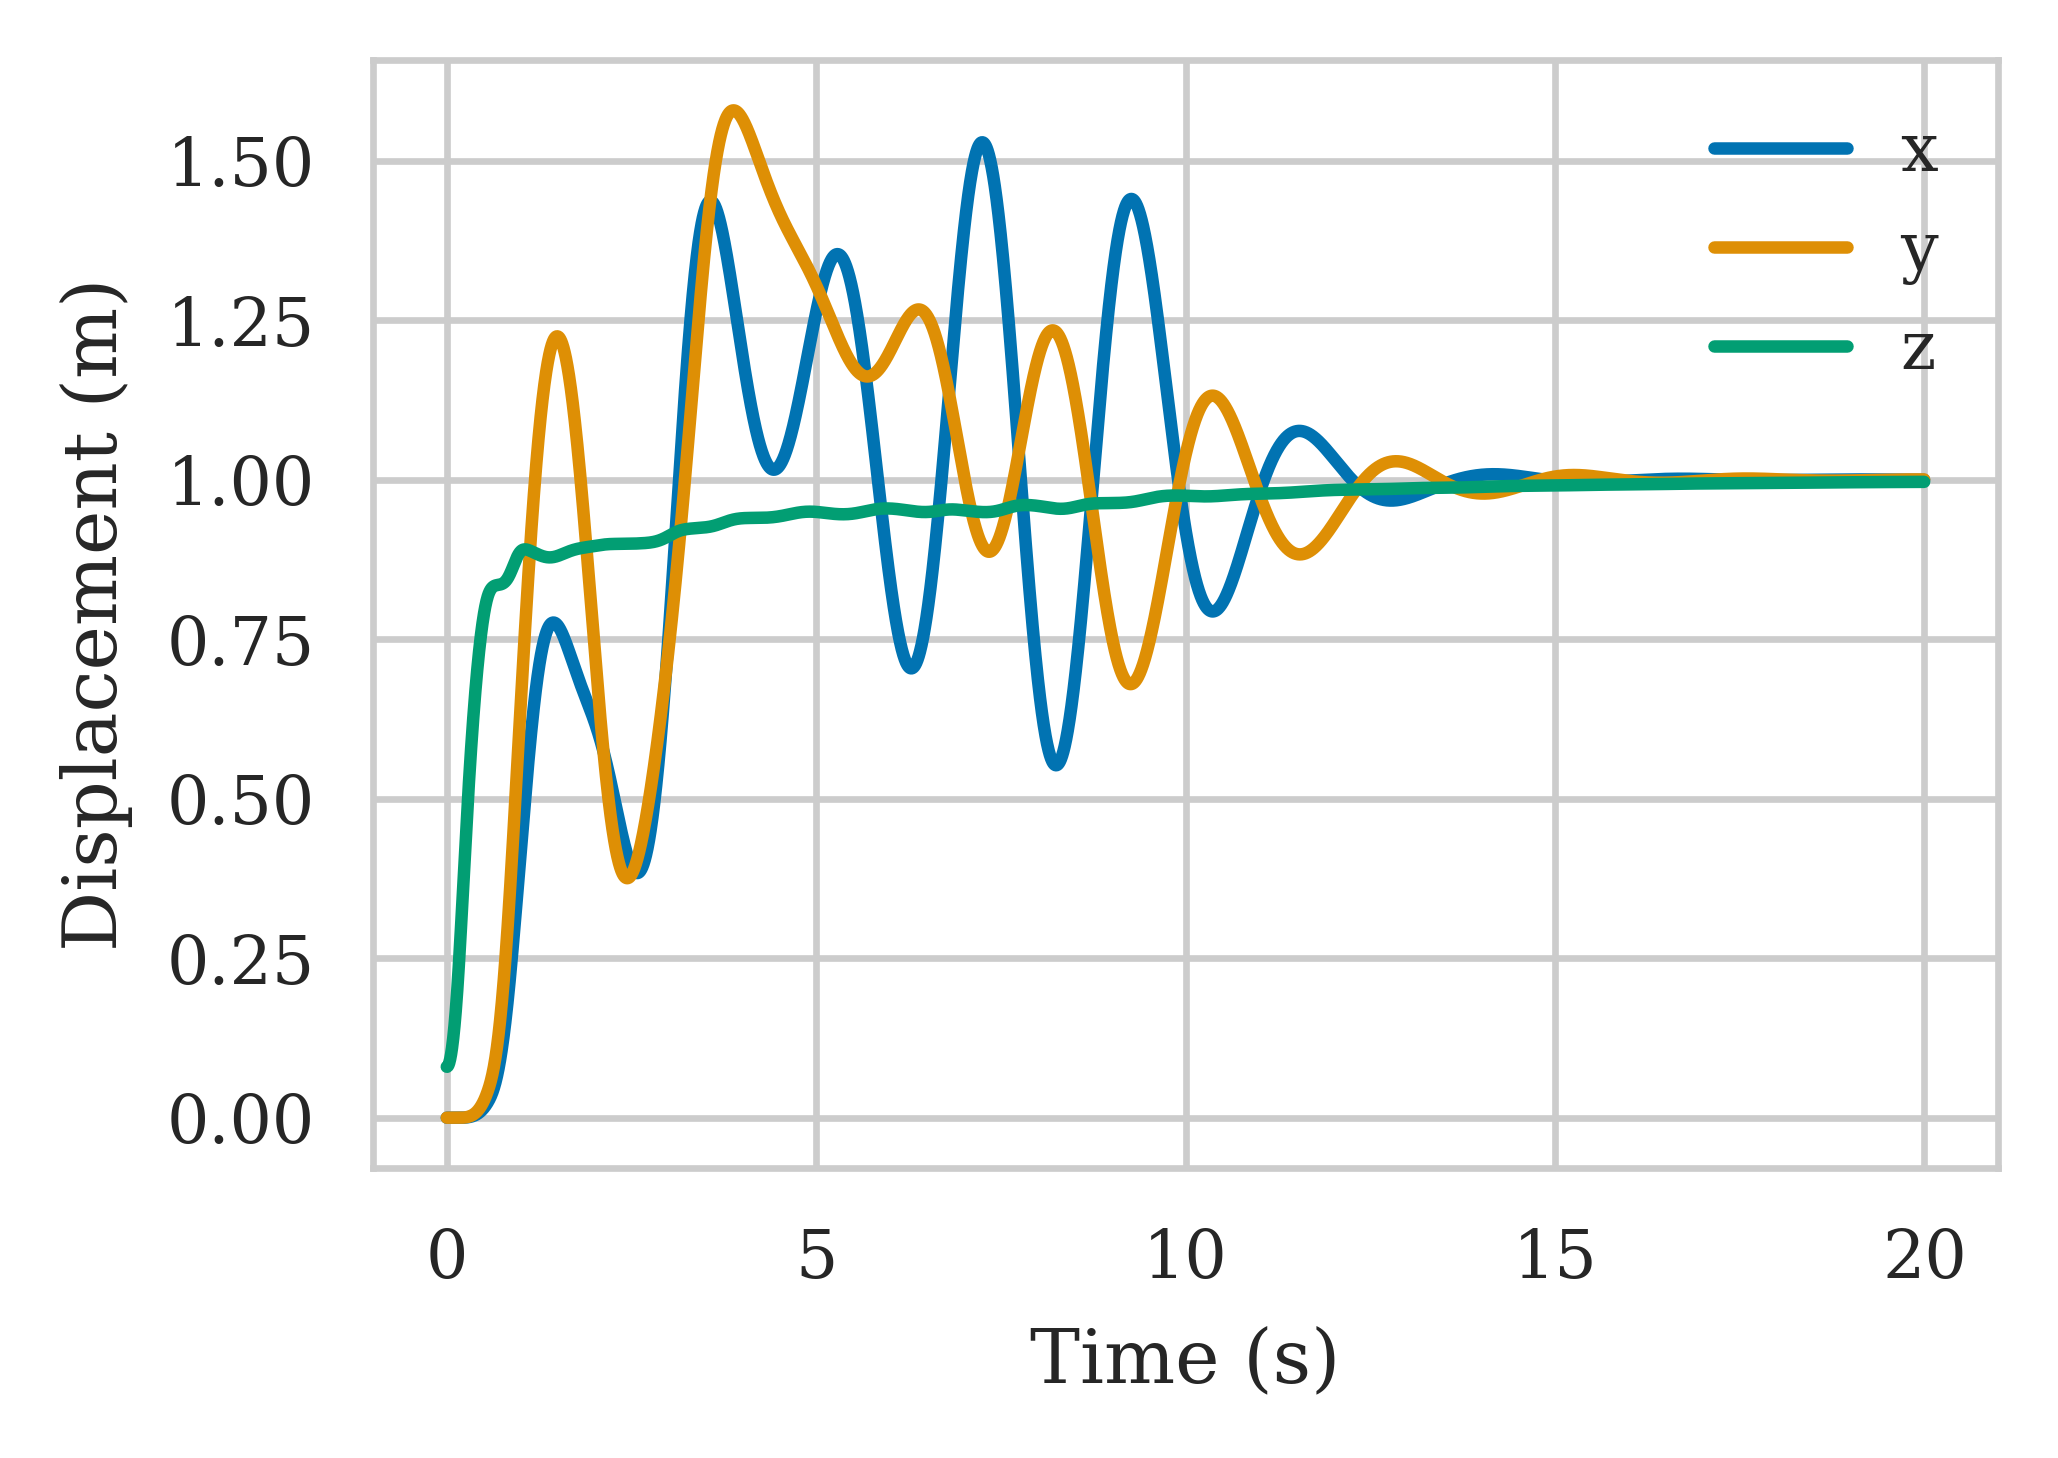

In [4]:
x = states[0, 0, :]
y = states[0, 1, :]
z = states[0, 2, :]

sns.set_style('whitegrid')
sns.set_palette('colorblind')

plt.rcParams.update({
    'font.family': 'serif',        # Use serif for print-friendly appearance
    'font.size': 9,                # General font size
    'axes.labelsize': 9,           # Axis label font size
    'axes.titlesize': 10,          # Title font size (unused if title removed)
    'legend.fontsize': 8,          # Legend font size
    'xtick.labelsize': 8,          # x-axis tick label size
    'ytick.labelsize': 8,          # y-axis tick label size
    'figure.dpi': 600              # High resolution for export
})

fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(timestamps.squeeze(), x, label='x')
ax.plot(timestamps.squeeze(), y, label='y')
ax.plot(timestamps.squeeze(), z, label='z')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Displacement (m)')

ax.legend(loc='best', frameon=False)

plt.tight_layout()

plt.savefig('mrac_position_control.png', dpi=600)
plt.show()

In [5]:
Xm = np.array(Xm)
Xm_ = Xm[:, 0:3, 0].T # shape is (3, 960)
xm = Xm_[0].squeeze()
ym = Xm_[1].squeeze()
zm = Xm_[2].squeeze()
timestamps = timestamps.squeeze()

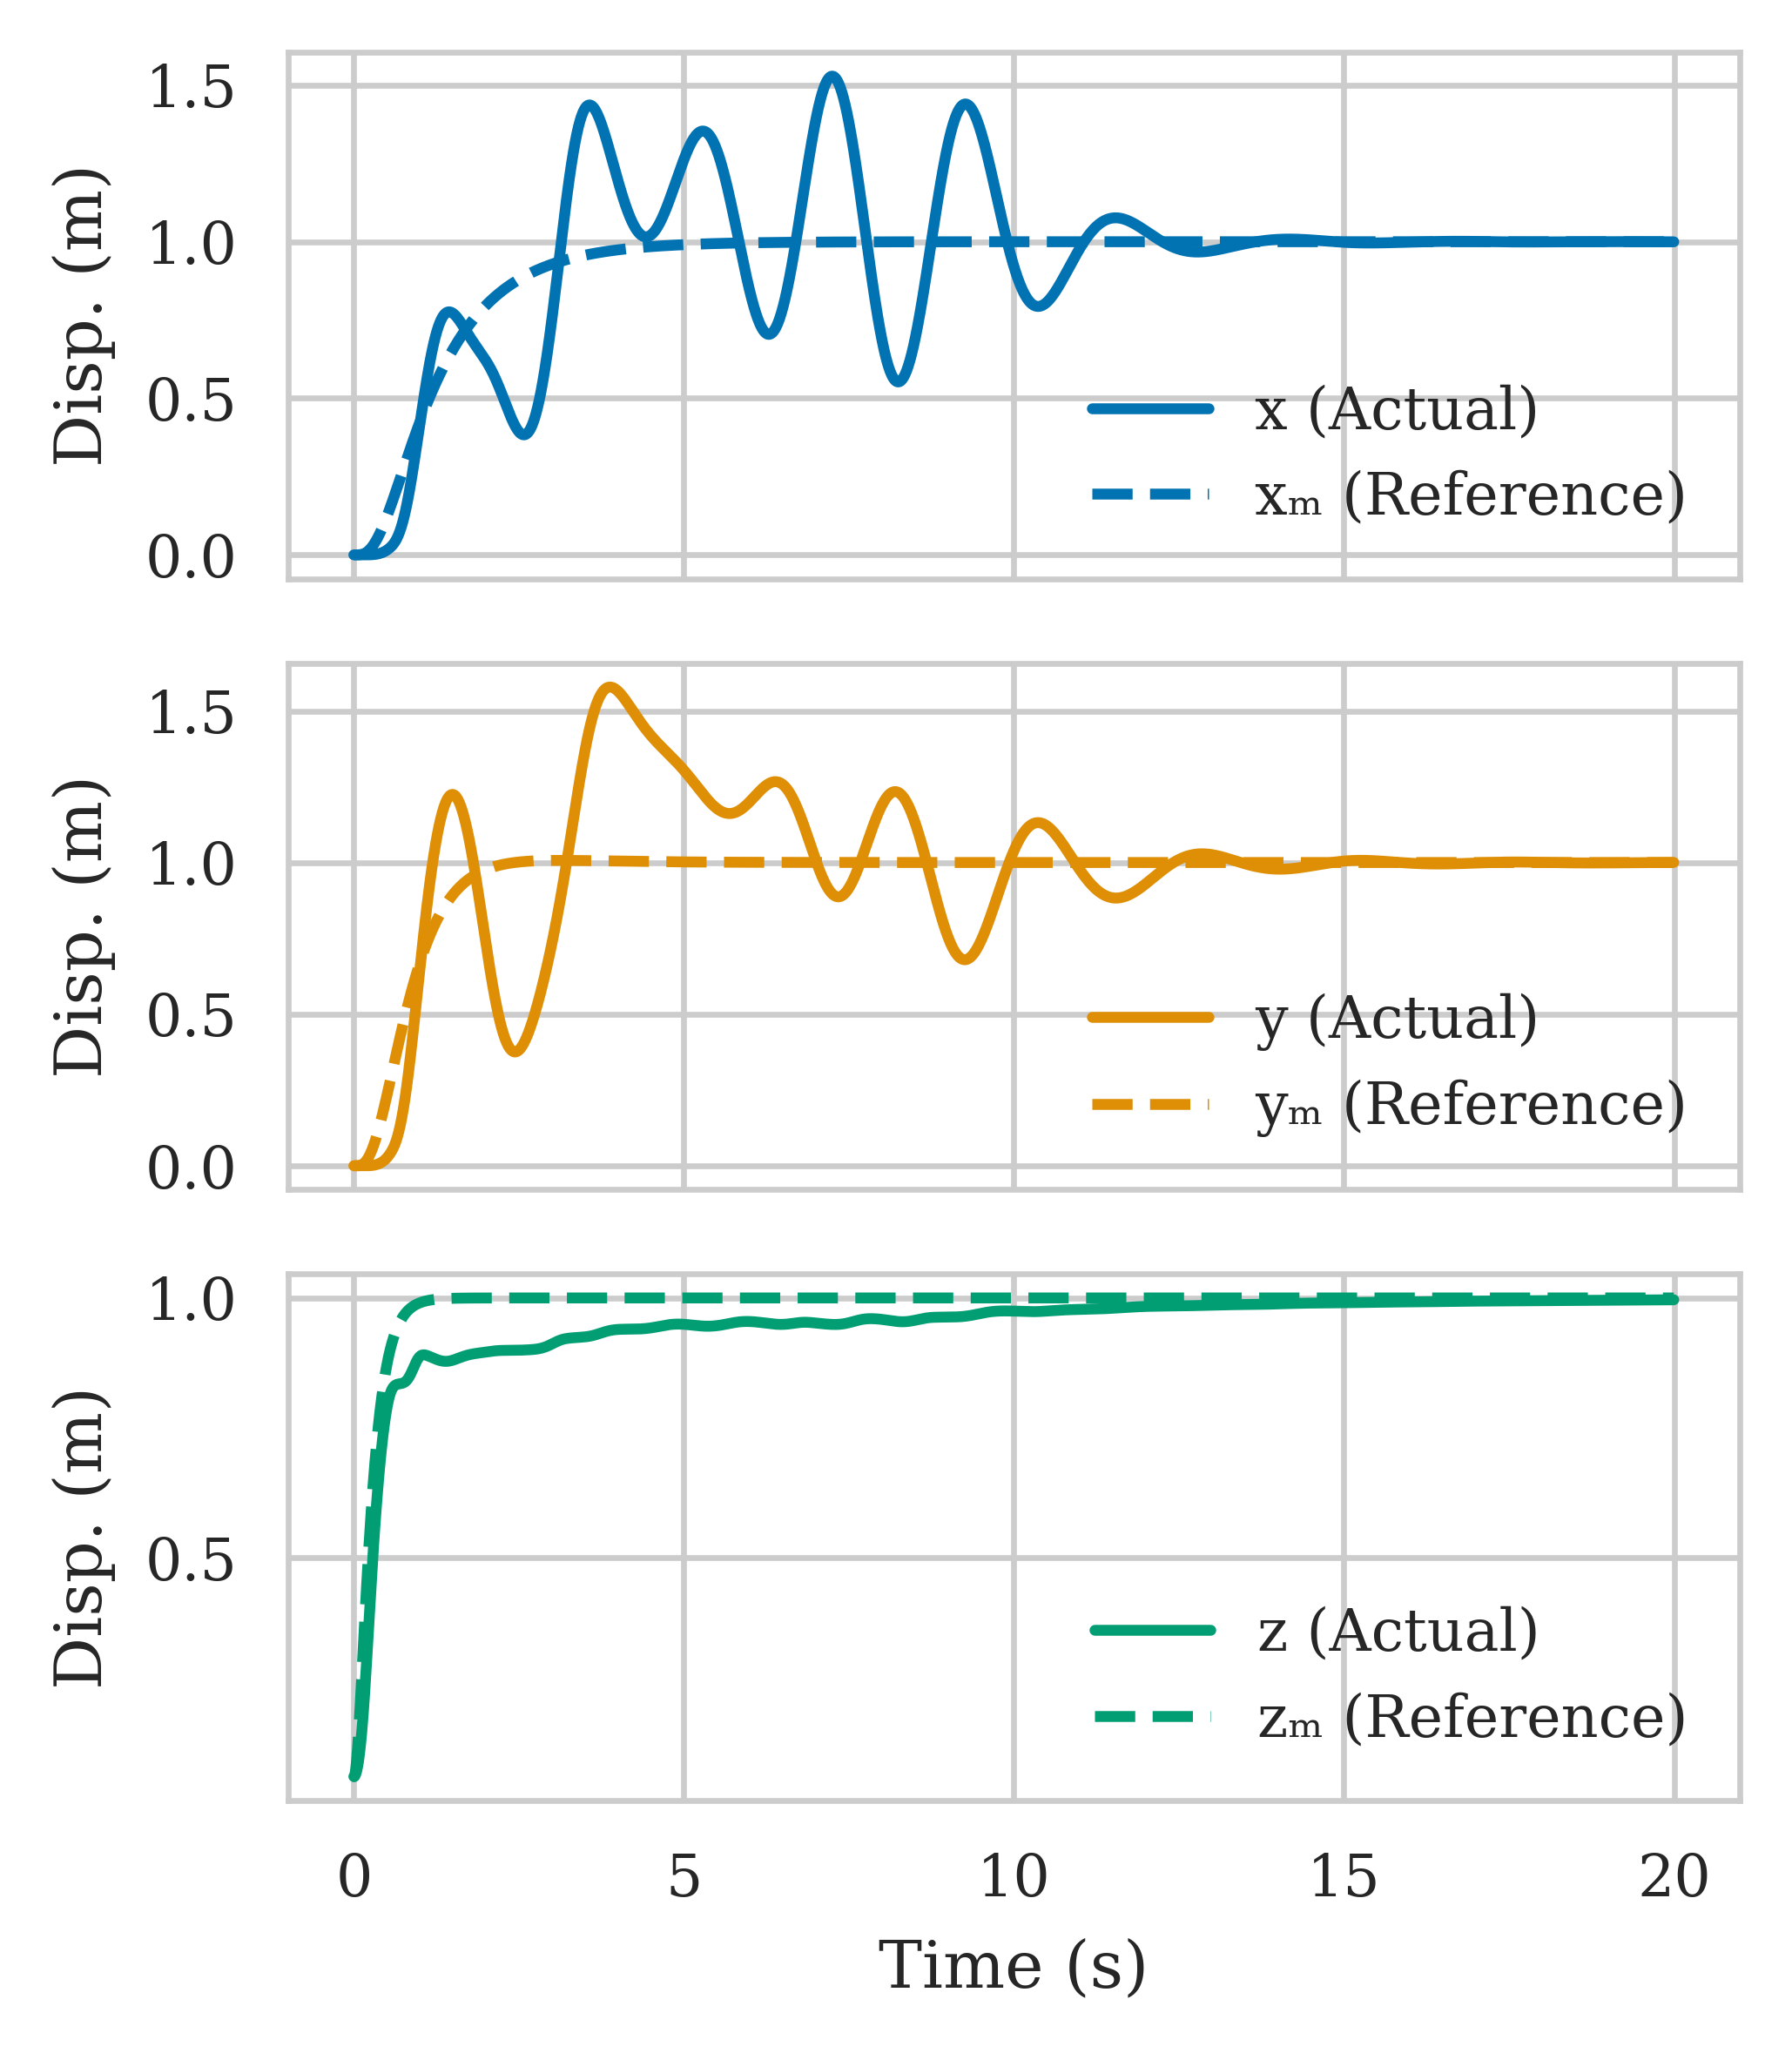

In [6]:
# sns.set_style('whitegrid')
# sns.set_palette('colorblind')

# plt.rcParams.update({
#     'font.family': 'serif',
#     'font.size': 9,
#     'axes.labelsize': 9,
#     'legend.fontsize': 8,
#     'xtick.labelsize': 8,
#     'ytick.labelsize': 8,
#     'figure.dpi': 600
# })

# fig, ax = plt.subplots(figsize=(3.5, 2.5))

# # Plot actual plant states with solid lines
# ax.plot(timestamps, x, label='x (Actual)', linestyle='-')
# ax.plot(timestamps, y, label='y (Actual)', linestyle='-')
# ax.plot(timestamps, z, label='z (Actual)', linestyle='-')

# # Plot reference model states with dashed lines
# ax.plot(timestamps, xm, label='x_m (Reference)', linestyle='--')
# ax.plot(timestamps, ym, label='y_m (Reference)', linestyle='--')
# ax.plot(timestamps, zm, label='z_m (Reference)', linestyle='--')

# # Axis labels and legend
# ax.set_xlabel('Time (s)')
# ax.set_ylabel('Displacement (m)')
# ax.legend(loc='best', frameon=False)

# plt.tight_layout()

# # Save the figure with high resolution (600 dpi is typical for IEEE)
# plt.savefig('mrac_position_control_.png', dpi=600)
# plt.show()

fig, axs = plt.subplots(3, 1, figsize=(3.5, 4), sharex=True)

labels = ['x', 'y', 'z']
actuals = [x, y, z]
refs = [xm, ym, zm]
colors = ['C0', 'C1', 'C2']

for i in range(3):
    axs[i].plot(timestamps, actuals[i], color=colors[i], linestyle='-', label=f'{labels[i]} (Actual)')
    axs[i].plot(timestamps, refs[i], color=colors[i], linestyle='--', label=f'{labels[i]}ₘ (Reference)')
    axs[i].set_ylabel('Disp. (m)')
    axs[i].legend(loc='best', frameon=False)
    
axs[-1].set_xlabel('Time (s)')

plt.tight_layout()
plt.savefig('mrac_subplot_version.png', dpi=600)
plt.show()


In [2]:
import os
import time
from datetime import datetime
import argparse
import gymnasium as gym
import numpy as np
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.evaluation import evaluate_policy

from gym_pybullet_drones.utils.Logger import Logger
from gym_pybullet_drones.envs.HoverAviary import HoverAviary
from gym_pybullet_drones.envs.MultiHoverAviary import MultiHoverAviary
from gym_pybullet_drones.utils.utils import sync, str2bool
from gym_pybullet_drones.utils.enums import ObservationType, ActionType

DEFAULT_GUI = True
DEFAULT_RECORD_VIDEO = False
DEFAULT_OUTPUT_FOLDER = 'results'
DEFAULT_COLAB = False

DEFAULT_OBS = ObservationType('kin') # 'kin' or 'rgb'
DEFAULT_ACT = ActionType('rpm') # 'rpm' or 'pid' or 'vel' or 'one_d_rpm' or 'one_d_pid'
DEFAULT_AGENTS = 2
DEFAULT_MA = False

def run(multiagent=DEFAULT_MA, output_folder=DEFAULT_OUTPUT_FOLDER, gui=DEFAULT_GUI, plot=True, colab=DEFAULT_COLAB, record_video=DEFAULT_RECORD_VIDEO, local=True):
    path = 'results/save-04.13.2025_13.19.04/best_model.zip'
    model = PPO.load(path)

    test_env = HoverAviary(gui=gui,
                            obs=DEFAULT_OBS,
                            act=DEFAULT_ACT,
                            record=record_video)
    test_env_nogui = HoverAviary(obs=DEFAULT_OBS, act=DEFAULT_ACT)

    logger = Logger(logging_freq_hz=int(test_env.CTRL_FREQ),
                num_drones=DEFAULT_AGENTS if multiagent else 1,
                output_folder=output_folder,
                colab=colab
                )

    mean_reward, std_reward = evaluate_policy(model,
                                              test_env_nogui,
                                              n_eval_episodes=10
                                              )
    print("\n\n\nMean reward ", mean_reward, " +- ", std_reward, "\n\n")

    obs, info = test_env.reset(seed=42, options={})
    start = time.time()
    for i in range((test_env.EPISODE_LEN_SEC+12)*test_env.CTRL_FREQ):
        action, _states = model.predict(obs,
                                        deterministic=True
                                        )
        obs, reward, terminated, truncated, info = test_env.step(action)
        obs2 = obs.squeeze()
        act2 = action.squeeze()
        print("Obs:", obs, "\tAction", action, "\tReward:", reward, "\tTerminated:", terminated, "\tTruncated:", truncated)
        if DEFAULT_OBS == ObservationType.KIN:
            if not multiagent:
                logger.log(drone=0,
                    timestamp=i/test_env.CTRL_FREQ,
                    state=np.hstack([obs2[0:3],
                                        np.zeros(4),
                                        obs2[3:15],
                                        act2
                                        ]),
                    control=np.zeros(12)
                    )
            else:
                for d in range(DEFAULT_AGENTS):
                    logger.log(drone=d,
                        timestamp=i/test_env.CTRL_FREQ,
                        state=np.hstack([obs2[d][0:3],
                                            np.zeros(4),
                                            obs2[d][3:15],
                                            act2[d]
                                            ]),
                        control=np.zeros(12)
                        )
        test_env.render()
        print(terminated)
        sync(i, start, test_env.CTRL_TIMESTEP)
        if terminated:
            obs = test_env.reset(seed=42, options={})
    test_env.close()

    states = logger.states
    controls = logger.controls
    timestamps = logger.timestamps
    return states, controls, timestamps

states, controls, timestamps = run()

[INFO] BaseAviary.__init__() loaded parameters from the drone's .urdf:
[INFO] m 0.027000, L 0.039700,
[INFO] ixx 0.000014, iyy 0.000014, izz 0.000022,
[INFO] kf 0.000000, km 0.000000,
[INFO] t2w 2.250000, max_speed_kmh 30.000000,
[INFO] gnd_eff_coeff 11.368590, prop_radius 0.023135,
[INFO] drag_xy_coeff 0.000001, drag_z_coeff 0.000001,
[INFO] dw_coeff_1 2267.180000, dw_coeff_2 0.160000, dw_coeff_3 -0.110000
Version = 4.1 Metal - 89.3
Vendor = Apple
Renderer = Apple M1
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
viewMatrix (0.642787516117096, -0.4393851161003113, 0.6275069713592529, 0.0, 0.766044557094574, 0.36868777871131897, -0.5265407562255859, 0.0, -0.0, 0.8191521167755127, 0.5735764503479004, 0.0, 2.1817449180616677e-07, 1.4121394542598864e-07, -5.000000476837158, 1.0)
projectionMatrix (0.7499999403953552, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, -1.0000200271606445, -1.0, 0.0, 0.0,

/Users/timii/miniforge3/envs/ai/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/timii/miniforge3/envs/ai/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


[INFO] BaseAviary.__init__() loaded parameters from the drone's .urdf:
[INFO] m 0.027000, L 0.039700,
[INFO] ixx 0.000014, iyy 0.000014, izz 0.000022,
[INFO] kf 0.000000, km 0.000000,
[INFO] t2w 2.250000, max_speed_kmh 30.000000,
[INFO] gnd_eff_coeff 11.368590, prop_radius 0.023135,
[INFO] drag_xy_coeff 0.000001, drag_z_coeff 0.000001,
[INFO] dw_coeff_1 2267.180000, dw_coeff_2 0.160000, dw_coeff_3 -0.110000


/Users/timii/miniforge3/envs/ai/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(





Mean reward  440.2913165092468  +-  0.4294293857941623 


Obs: [[ 9.99989629e-01  9.99989688e-01  8.87178600e-01  4.78407601e-03
   1.03835000e-05  1.03375869e-05  1.12821385e-01 -8.24386068e-03
   8.28230008e-03 -4.78407601e-03  9.99920249e-01 -1.65686626e-02
   1.64851490e-02 -9.70541686e-03  1.10821822e-03  1.10176904e-03
   1.71324871e-02 -8.77504349e-01  8.84553552e-01 -5.10137618e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000

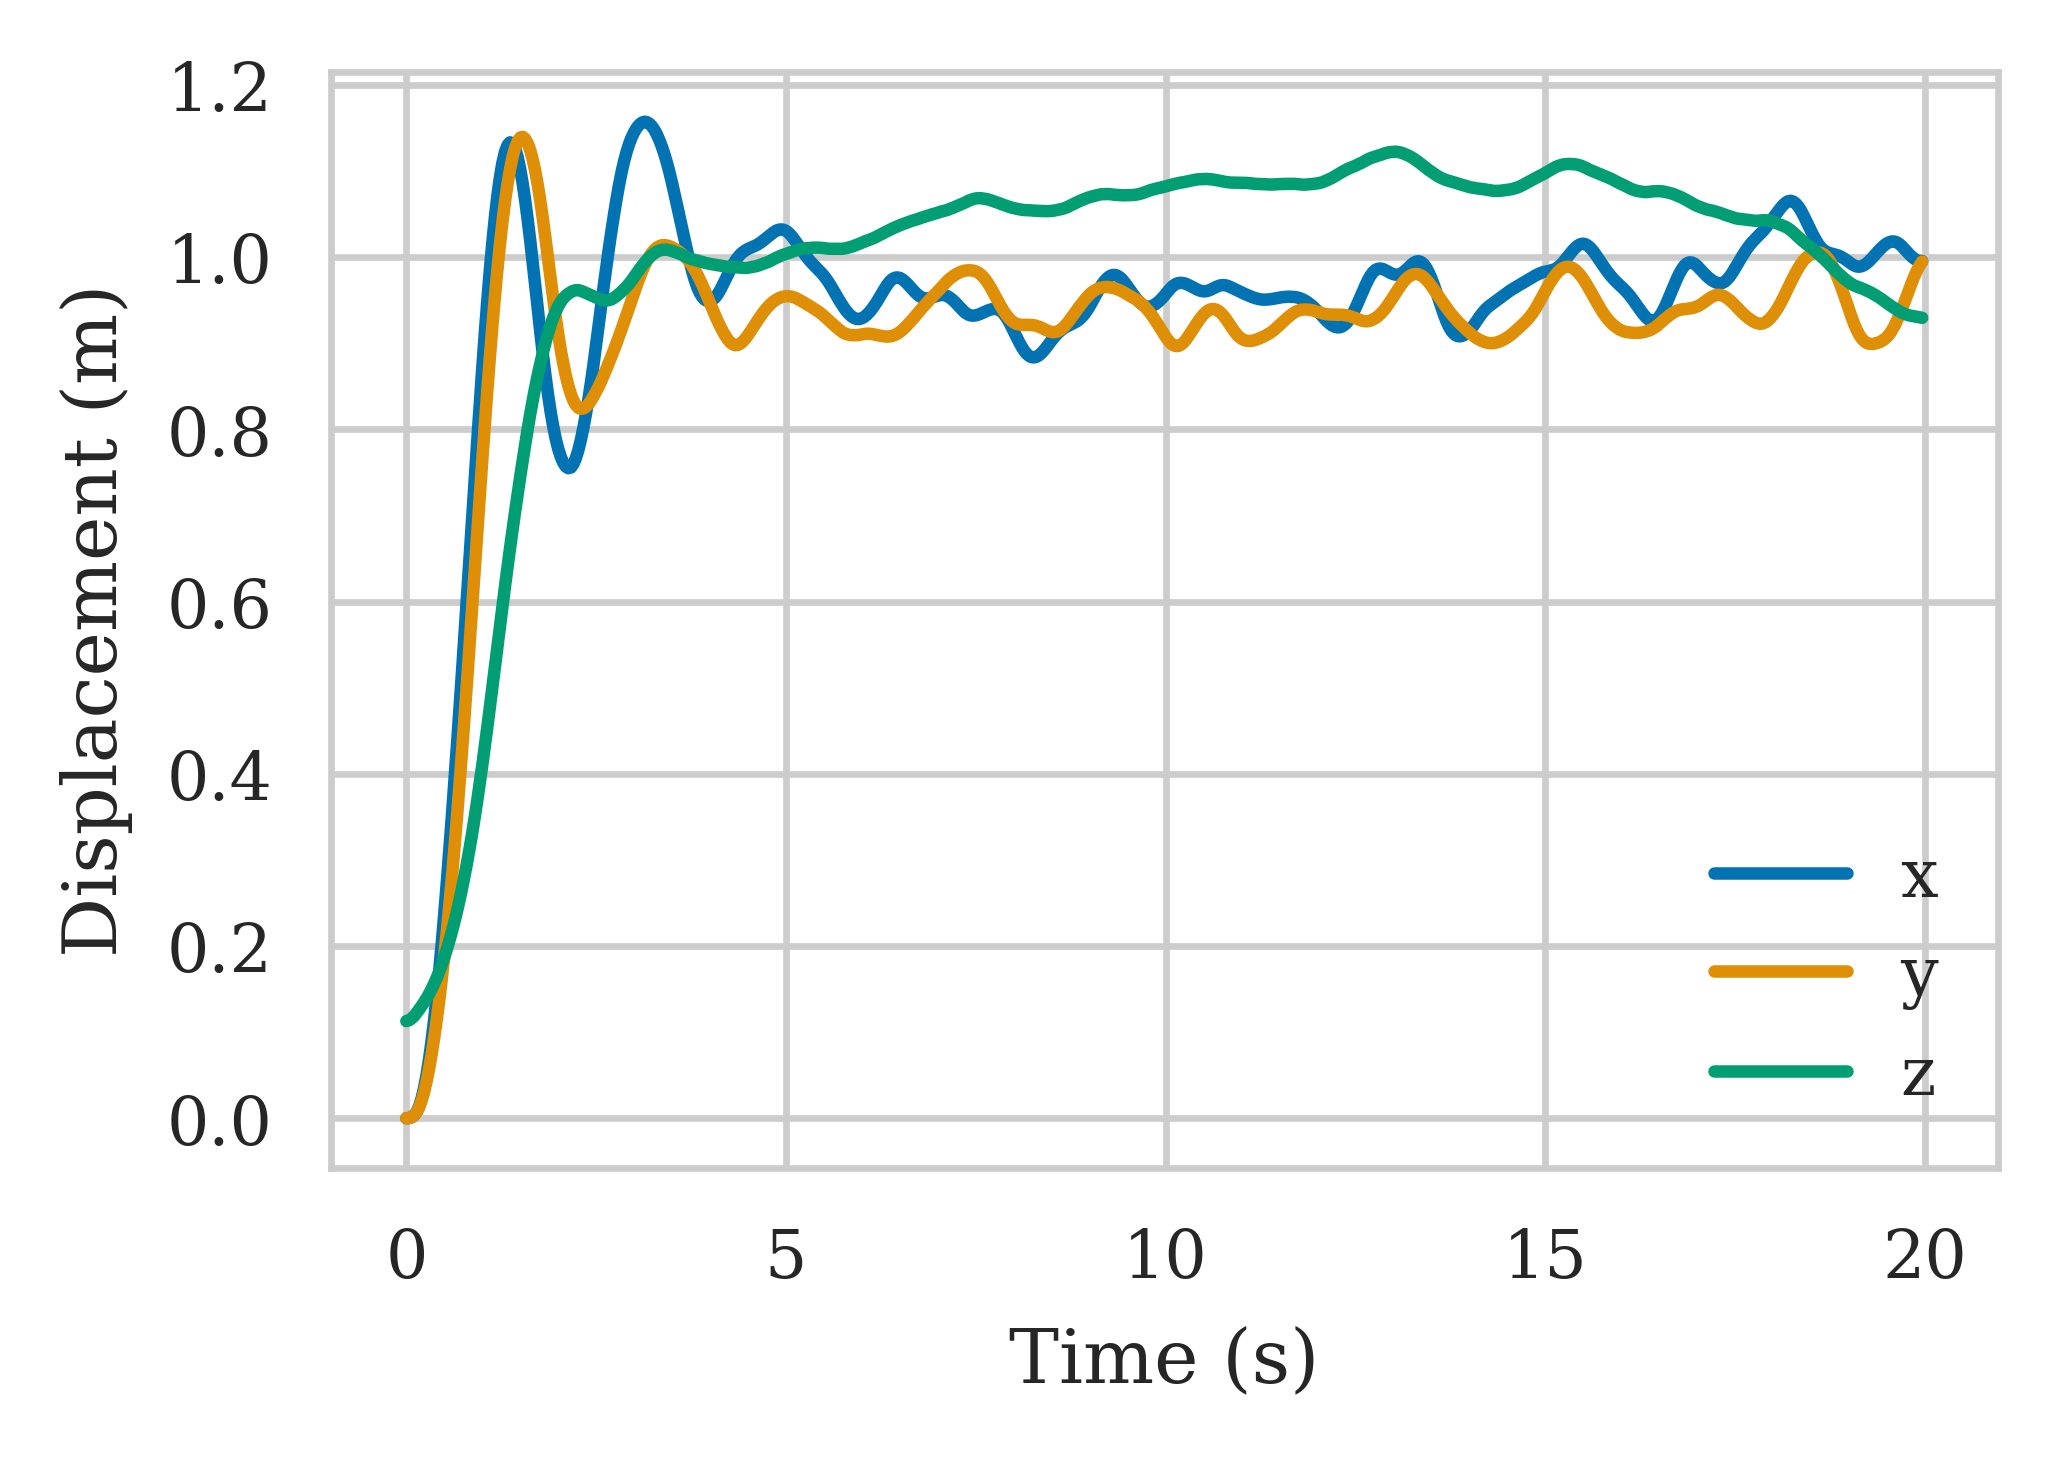

In [3]:
x = 1 - states[0, 0, :]
y = 1 - states[0, 1, :]
z = 1 - states[0, 2, :]

sns.set_style('whitegrid')
sns.set_palette('colorblind')

plt.rcParams.update({
    'font.family': 'serif',        # Use serif for print-friendly appearance
    'font.size': 9,                # General font size
    'axes.labelsize': 9,           # Axis label font size
    'axes.titlesize': 10,          # Title font size (unused if title removed)
    'legend.fontsize': 8,          # Legend font size
    'xtick.labelsize': 8,          # x-axis tick label size
    'ytick.labelsize': 8,          # y-axis tick label size
    'figure.dpi': 600              # High resolution for export
})

fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(timestamps.squeeze(), x, label='x')
ax.plot(timestamps.squeeze(), y, label='y')
ax.plot(timestamps.squeeze(), z, label='z')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Displacement (m)')

ax.legend(loc='best', frameon=False)

plt.tight_layout()

plt.savefig('rl_position_control.png', dpi=600)
plt.show()